# TensorFlow Regression Example

## Creating Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 1 Million Points
x_data = np.linspace(0.0,10.0,1000000)

In [3]:
x_data

array([0.000000e+00, 1.000001e-05, 2.000002e-05, ..., 9.999980e+00,
       9.999990e+00, 1.000000e+01])

In [4]:
noise = np.random.randn(len(x_data))

In [5]:
# y = mx + b + noise_levels
b = 5

y_true =  (0.5 * x_data ) + 5 + noise

In [6]:
my_data = pd.concat([pd.DataFrame(data=x_data,columns=['X Data']),pd.DataFrame(data=y_true,columns=['Y'])],axis=1)

In [7]:
my_data.head()

,X Data,Y
0,0.00000,4.566885
1,0.00001,7.020876
2,0.00002,5.205278
3,0.00003,6.352417
4,0.00004,4.492310


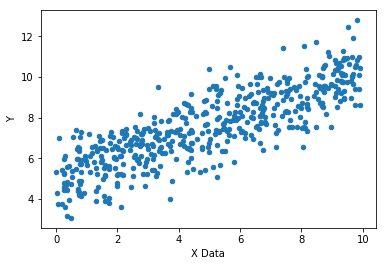

In [8]:
my_data.sample(n=500).plot(kind='scatter',x='X Data',y='Y')

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [11]:
import tensorflow as tf

In [12]:
# Random 10 points to grab
batch_size = 8

** Variables **

In [13]:
m = tf.Variable(0.5)
b = tf.Variable(1.0)

** Placeholders **

In [14]:
xph = tf.placeholder(tf.float32,[batch_size])
yph = tf.placeholder(tf.float32,[batch_size])

** Graph **

In [15]:
y_model = m*xph + b

** Loss Function **

In [16]:
error = tf.reduce_sum(tf.square(yph-y_model))

** Optimizer **

In [17]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

** Initialize Variables **

In [18]:
init = tf.global_variables_initializer()

### Session

In [24]:
with tf.Session() as sess:
    
    sess.run(init)
    
    batches = 10000
    
    for i in range(batches):
        
        rand_ind = np.random.randint(len(x_data),size=batch_size)
        
        feed = {xph:x_data[rand_ind],yph:y_true[rand_ind]}
        
        sess.run(train,feed_dict=feed)
        
    model_m,model_b = sess.run([m,b])

In [25]:
model_m

0.49251458

In [26]:
model_b

5.0106483

### Results

In [27]:
y_hat = x_data * model_m + model_b

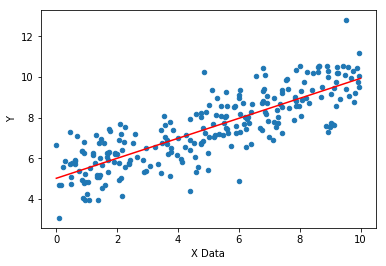

In [28]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'r')

## tf.estimator API

Much simpler API for basic tasks like regression! We'll talk about more abstractions like TF-Slim later on.

In [29]:
feat_cols = [tf.feature_column.numeric_column('x',shape=[1])]

In [30]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/_6/y3kprftx5gz9pzhx9yk35dmc0000gn/T/tmp3063kg48', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11f55b588>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train Test Split

We haven't actually performed a train test split yet! So let's do that on our data now and perform a more realistic version of a Regression Task

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)

In [33]:
print(x_train.shape)
print(y_train.shape)

print(x_eval.shape)
print(y_eval.shape)

(700000,)
(700000,)
(300000,)
(300000,)


### Set up Estimator Inputs

In [34]:
# Can also do .pandas_input_fn
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=None,shuffle=True)

In [35]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=1000,shuffle=False)

In [36]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval},y_eval,batch_size=4,num_epochs=1000,shuffle=False)

### Train the Estimator

In [37]:
estimator.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/_6/y3kprftx5gz9pzhx9yk35dmc0000gn/T/tmp3063kg48/model.ckpt.
INFO:tensorflow:loss = 224.43385, step = 1
INFO:tensorflow:global_step/sec: 1478.61
INFO:tensorflow:loss = 10.979112, step = 101 (0.069 sec)
INFO:tensorflow:global_step/sec: 1774.81
INFO:tensorflow:loss = 11.090941, step = 201 (0.056 sec)
INFO:tensorflow:global_step/sec: 1770.85
INFO:tensorflow:loss = 4.184858, step = 301 (0.057 sec)
INFO:tensorflow:global_step/sec: 1792.56
INFO:tensorflow:loss = 10.941061, step = 401 (0.056 sec)
INFO:tensorflow:global_step/sec: 1801.9
INFO:tensorflow:loss = 15.007575, step = 501 (0.055 sec)
INFO:tensorflow:global_step/sec: 1825.83
INFO:tensorflow:loss = 1.6429589, step = 601 (0.055 sec)
INFO:tensorflow:global_step/sec: 1630.44
INFO:tensorflow:loss = 3.909895, step = 701 (0.061 sec)
INFO:tensorflow:global_step/sec: 1598.49
INFO:tensorflow:loss = 6.133358, step = 801 (0.063 sec)
INFO:tensorflo

### Evaluation

In [38]:
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

INFO:tensorflow:Starting evaluation at 2018-01-29-02:23:24
INFO:tensorflow:Restoring parameters from /var/folders/_6/y3kprftx5gz9pzhx9yk35dmc0000gn/T/tmp3063kg48/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:E

INFO:tensorflow:Evaluation [215/1000]
INFO:tensorflow:Evaluation [216/1000]
INFO:tensorflow:Evaluation [217/1000]
INFO:tensorflow:Evaluation [218/1000]
INFO:tensorflow:Evaluation [219/1000]
INFO:tensorflow:Evaluation [220/1000]
INFO:tensorflow:Evaluation [221/1000]
INFO:tensorflow:Evaluation [222/1000]
INFO:tensorflow:Evaluation [223/1000]
INFO:tensorflow:Evaluation [224/1000]
INFO:tensorflow:Evaluation [225/1000]
INFO:tensorflow:Evaluation [226/1000]
INFO:tensorflow:Evaluation [227/1000]
INFO:tensorflow:Evaluation [228/1000]
INFO:tensorflow:Evaluation [229/1000]
INFO:tensorflow:Evaluation [230/1000]
INFO:tensorflow:Evaluation [231/1000]
INFO:tensorflow:Evaluation [232/1000]
INFO:tensorflow:Evaluation [233/1000]
INFO:tensorflow:Evaluation [234/1000]
INFO:tensorflow:Evaluation [235/1000]
INFO:tensorflow:Evaluation [236/1000]
INFO:tensorflow:Evaluation [237/1000]
INFO:tensorflow:Evaluation [238/1000]
INFO:tensorflow:Evaluation [239/1000]
INFO:tensorflow:Evaluation [240/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [431/1000]
INFO:tensorflow:Evaluation [432/1000]
INFO:tensorflow:Evaluation [433/1000]
INFO:tensorflow:Evaluation [434/1000]
INFO:tensorflow:Evaluation [435/1000]
INFO:tensorflow:Evaluation [436/1000]
INFO:tensorflow:Evaluation [437/1000]
INFO:tensorflow:Evaluation [438/1000]
INFO:tensorflow:Evaluation [439/1000]
INFO:tensorflow:Evaluation [440/1000]
INFO:tensorflow:Evaluation [441/1000]
INFO:tensorflow:Evaluation [442/1000]
INFO:tensorflow:Evaluation [443/1000]
INFO:tensorflow:Evaluation [444/1000]
INFO:tensorflow:Evaluation [445/1000]
INFO:tensorflow:Evaluation [446/1000]
INFO:tensorflow:Evaluation [447/1000]
INFO:tensorflow:Evaluation [448/1000]
INFO:tensorflow:Evaluation [449/1000]
INFO:tensorflow:Evaluation [450/1000]
INFO:tensorflow:Evaluation [451/1000]
INFO:tensorflow:Evaluation [452/1000]
INFO:tensorflow:Evaluation [453/1000]
INFO:tensorflow:Evaluation [454/1000]
INFO:tensorflow:Evaluation [455/1000]
INFO:tensorflow:Evaluation [456/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [647/1000]
INFO:tensorflow:Evaluation [648/1000]
INFO:tensorflow:Evaluation [649/1000]
INFO:tensorflow:Evaluation [650/1000]
INFO:tensorflow:Evaluation [651/1000]
INFO:tensorflow:Evaluation [652/1000]
INFO:tensorflow:Evaluation [653/1000]
INFO:tensorflow:Evaluation [654/1000]
INFO:tensorflow:Evaluation [655/1000]
INFO:tensorflow:Evaluation [656/1000]
INFO:tensorflow:Evaluation [657/1000]
INFO:tensorflow:Evaluation [658/1000]
INFO:tensorflow:Evaluation [659/1000]
INFO:tensorflow:Evaluation [660/1000]
INFO:tensorflow:Evaluation [661/1000]
INFO:tensorflow:Evaluation [662/1000]
INFO:tensorflow:Evaluation [663/1000]
INFO:tensorflow:Evaluation [664/1000]
INFO:tensorflow:Evaluation [665/1000]
INFO:tensorflow:Evaluation [666/1000]
INFO:tensorflow:Evaluation [667/1000]
INFO:tensorflow:Evaluation [668/1000]
INFO:tensorflow:Evaluation [669/1000]
INFO:tensorflow:Evaluation [670/1000]
INFO:tensorflow:Evaluation [671/1000]
INFO:tensorflow:Evaluation [672/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [863/1000]
INFO:tensorflow:Evaluation [864/1000]
INFO:tensorflow:Evaluation [865/1000]
INFO:tensorflow:Evaluation [866/1000]
INFO:tensorflow:Evaluation [867/1000]
INFO:tensorflow:Evaluation [868/1000]
INFO:tensorflow:Evaluation [869/1000]
INFO:tensorflow:Evaluation [870/1000]
INFO:tensorflow:Evaluation [871/1000]
INFO:tensorflow:Evaluation [872/1000]
INFO:tensorflow:Evaluation [873/1000]
INFO:tensorflow:Evaluation [874/1000]
INFO:tensorflow:Evaluation [875/1000]
INFO:tensorflow:Evaluation [876/1000]
INFO:tensorflow:Evaluation [877/1000]
INFO:tensorflow:Evaluation [878/1000]
INFO:tensorflow:Evaluation [879/1000]
INFO:tensorflow:Evaluation [880/1000]
INFO:tensorflow:Evaluation [881/1000]
INFO:tensorflow:Evaluation [882/1000]
INFO:tensorflow:Evaluation [883/1000]
INFO:tensorflow:Evaluation [884/1000]
INFO:tensorflow:Evaluation [885/1000]
INFO:tensorflow:Evaluation [886/1000]
INFO:tensorflow:Evaluation [887/1000]
INFO:tensorflow:Evaluation [888/1000]
INFO:tensorf

In [39]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

INFO:tensorflow:Starting evaluation at 2018-01-29-02:28:38
INFO:tensorflow:Restoring parameters from /var/folders/_6/y3kprftx5gz9pzhx9yk35dmc0000gn/T/tmp3063kg48/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:E

INFO:tensorflow:Evaluation [215/1000]
INFO:tensorflow:Evaluation [216/1000]
INFO:tensorflow:Evaluation [217/1000]
INFO:tensorflow:Evaluation [218/1000]
INFO:tensorflow:Evaluation [219/1000]
INFO:tensorflow:Evaluation [220/1000]
INFO:tensorflow:Evaluation [221/1000]
INFO:tensorflow:Evaluation [222/1000]
INFO:tensorflow:Evaluation [223/1000]
INFO:tensorflow:Evaluation [224/1000]
INFO:tensorflow:Evaluation [225/1000]
INFO:tensorflow:Evaluation [226/1000]
INFO:tensorflow:Evaluation [227/1000]
INFO:tensorflow:Evaluation [228/1000]
INFO:tensorflow:Evaluation [229/1000]
INFO:tensorflow:Evaluation [230/1000]
INFO:tensorflow:Evaluation [231/1000]
INFO:tensorflow:Evaluation [232/1000]
INFO:tensorflow:Evaluation [233/1000]
INFO:tensorflow:Evaluation [234/1000]
INFO:tensorflow:Evaluation [235/1000]
INFO:tensorflow:Evaluation [236/1000]
INFO:tensorflow:Evaluation [237/1000]
INFO:tensorflow:Evaluation [238/1000]
INFO:tensorflow:Evaluation [239/1000]
INFO:tensorflow:Evaluation [240/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [431/1000]
INFO:tensorflow:Evaluation [432/1000]
INFO:tensorflow:Evaluation [433/1000]
INFO:tensorflow:Evaluation [434/1000]
INFO:tensorflow:Evaluation [435/1000]
INFO:tensorflow:Evaluation [436/1000]
INFO:tensorflow:Evaluation [437/1000]
INFO:tensorflow:Evaluation [438/1000]
INFO:tensorflow:Evaluation [439/1000]
INFO:tensorflow:Evaluation [440/1000]
INFO:tensorflow:Evaluation [441/1000]
INFO:tensorflow:Evaluation [442/1000]
INFO:tensorflow:Evaluation [443/1000]
INFO:tensorflow:Evaluation [444/1000]
INFO:tensorflow:Evaluation [445/1000]
INFO:tensorflow:Evaluation [446/1000]
INFO:tensorflow:Evaluation [447/1000]
INFO:tensorflow:Evaluation [448/1000]
INFO:tensorflow:Evaluation [449/1000]
INFO:tensorflow:Evaluation [450/1000]
INFO:tensorflow:Evaluation [451/1000]
INFO:tensorflow:Evaluation [452/1000]
INFO:tensorflow:Evaluation [453/1000]
INFO:tensorflow:Evaluation [454/1000]
INFO:tensorflow:Evaluation [455/1000]
INFO:tensorflow:Evaluation [456/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [647/1000]
INFO:tensorflow:Evaluation [648/1000]
INFO:tensorflow:Evaluation [649/1000]
INFO:tensorflow:Evaluation [650/1000]
INFO:tensorflow:Evaluation [651/1000]
INFO:tensorflow:Evaluation [652/1000]
INFO:tensorflow:Evaluation [653/1000]
INFO:tensorflow:Evaluation [654/1000]
INFO:tensorflow:Evaluation [655/1000]
INFO:tensorflow:Evaluation [656/1000]
INFO:tensorflow:Evaluation [657/1000]
INFO:tensorflow:Evaluation [658/1000]
INFO:tensorflow:Evaluation [659/1000]
INFO:tensorflow:Evaluation [660/1000]
INFO:tensorflow:Evaluation [661/1000]
INFO:tensorflow:Evaluation [662/1000]
INFO:tensorflow:Evaluation [663/1000]
INFO:tensorflow:Evaluation [664/1000]
INFO:tensorflow:Evaluation [665/1000]
INFO:tensorflow:Evaluation [666/1000]
INFO:tensorflow:Evaluation [667/1000]
INFO:tensorflow:Evaluation [668/1000]
INFO:tensorflow:Evaluation [669/1000]
INFO:tensorflow:Evaluation [670/1000]
INFO:tensorflow:Evaluation [671/1000]
INFO:tensorflow:Evaluation [672/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [863/1000]
INFO:tensorflow:Evaluation [864/1000]
INFO:tensorflow:Evaluation [865/1000]
INFO:tensorflow:Evaluation [866/1000]
INFO:tensorflow:Evaluation [867/1000]
INFO:tensorflow:Evaluation [868/1000]
INFO:tensorflow:Evaluation [869/1000]
INFO:tensorflow:Evaluation [870/1000]
INFO:tensorflow:Evaluation [871/1000]
INFO:tensorflow:Evaluation [872/1000]
INFO:tensorflow:Evaluation [873/1000]
INFO:tensorflow:Evaluation [874/1000]
INFO:tensorflow:Evaluation [875/1000]
INFO:tensorflow:Evaluation [876/1000]
INFO:tensorflow:Evaluation [877/1000]
INFO:tensorflow:Evaluation [878/1000]
INFO:tensorflow:Evaluation [879/1000]
INFO:tensorflow:Evaluation [880/1000]
INFO:tensorflow:Evaluation [881/1000]
INFO:tensorflow:Evaluation [882/1000]
INFO:tensorflow:Evaluation [883/1000]
INFO:tensorflow:Evaluation [884/1000]
INFO:tensorflow:Evaluation [885/1000]
INFO:tensorflow:Evaluation [886/1000]
INFO:tensorflow:Evaluation [887/1000]
INFO:tensorflow:Evaluation [888/1000]
INFO:tensorf

In [40]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 1.1147686, 'loss': 4.4590745, 'global_step': 1000}
eval metrics: {'average_loss': 1.1255335, 'loss': 4.502134, 'global_step': 1000}


### Predictions

In [41]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,10)},shuffle=False)

In [42]:
list(estimator.predict(input_fn=input_fn_predict))

INFO:tensorflow:Restoring parameters from /var/folders/_6/y3kprftx5gz9pzhx9yk35dmc0000gn/T/tmp3063kg48/model.ckpt-1000


[{'predictions': array([4.3212314], dtype=float32)},
 {'predictions': array([4.998805], dtype=float32)},
 {'predictions': array([5.676379], dtype=float32)},
 {'predictions': array([6.3539524], dtype=float32)},
 {'predictions': array([7.0315266], dtype=float32)},
 {'predictions': array([7.7091], dtype=float32)},
 {'predictions': array([8.386674], dtype=float32)},
 {'predictions': array([9.064247], dtype=float32)},
 {'predictions': array([9.741821], dtype=float32)},
 {'predictions': array([10.419395], dtype=float32)}]

In [43]:
predictions = []# np.array([])
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Restoring parameters from /var/folders/_6/y3kprftx5gz9pzhx9yk35dmc0000gn/T/tmp3063kg48/model.ckpt-1000


In [44]:
predictions

[array([4.3212314], dtype=float32),
 array([4.998805], dtype=float32),
 array([5.676379], dtype=float32),
 array([6.3539524], dtype=float32),
 array([7.0315266], dtype=float32),
 array([7.7091], dtype=float32),
 array([8.386674], dtype=float32),
 array([9.064247], dtype=float32),
 array([9.741821], dtype=float32),
 array([10.419395], dtype=float32)]

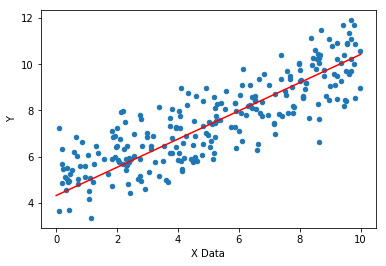

In [45]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'r')